## Import modules

In [1]:
# import math
# import operator
import sys
import time
# from collections import OrderedDict
# from functools import reduce

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from skhep.visual import MplPlotter as skh_plt

# import multiprocessing
import concurrent.futures

from XRootD import client
from XRootD.client.flags import DirListFlags, StatInfoFlags, OpenFlags, MkDirFlags, QueryCode
# import xrdfs_find

Import local classes from utils

In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils.ObjectExtractor
%aimport utils.PlotMaker
%aimport utils.HistogramContainer
%aimport utils.HistogramCalculator
OE = utils.ObjectExtractor
PM = utils.PlotMaker
HCont = utils.HistogramContainer
HCalc = utils.HistogramCalculator

## Global initialization

In [3]:
print(sys.version_info)
# num_cores = multiprocessing.cpu_count()
# print(num_cores)

executor = concurrent.futures.ThreadPoolExecutor(48)

plt.style.use('default')
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams.update({'font.size': 10})

numCuts = np.arange(0,6)

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)


In [4]:
all_plot_vars = ['metpt', 'jetpt','metjetphi', 'metmuphi', 'leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
plot_vars_metjet = all_plot_vars[0:4] #['metpt', 'jetpt', 'metjetphi', 'metmuphi']
plot_vars_muons = all_plot_vars[4:8] #['leadingmupt', 'subleadingmupt', 'recodr', 'recovertex']
cutflow_vars = ['cutflow_incl', 'cutflow_excl']
all_plot_xlabels = [
    'MET [GeV]', 'Leading jet pT [GeV]', '$\Delta\Phi$(MET, jet)', '$\Delta\Phi$(MET, di-muon)',
    'Leading muon pT [GeV]', 'Subleading muon pT [GeV]', 'dR(muons)', 'Di-muon vertex [cm]']

In [5]:
histos = {}
all_bins = {}
for plot_var in all_plot_vars:
    histos[plot_var] = {}
    all_bins[plot_var] = 60
histos['cutflow_incl'] = {}
histos['cutflow_excl'] = {}
histos['sumgenwgt'] = {}

## Process signal

In [14]:
masses = [('60p0','20p0'),('6p0','2p0'),('52p5','5p0'),('5p25','0p5')]
def print_masses(mass):
    return f'({float(mass[0].replace("p","."))-float(mass[1].replace("p","."))/2}, ' + \
           f'{float(mass[0].replace("p","."))+float(mass[1].replace("p","."))/2}) GeV'
    
mchis = dict([(mass[0], print_masses(mass)) for mass in masses])
ctaus = [10]#, 10, 100, 1000]

labels = [ f'cut{cut}' for cut in numCuts ]
cut_descriptions = [
    'cut1: MET/MHT trigger fired (120 GeV)',
    'cut2: j1 pT > 120 GeV, <= 2j w/ pT > 30 GeV',
    'cut3: mu1 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
    'cut4: mu2 pT > 5 GeV, 0.1 < |dxy| < 700 cm',
    r'cut5: $|\Delta\Phi$(MET, mu pair)| < 0.4',
]

branch_path = 'SREffi_gbm'
base_dir = '../Firefighter/washAOD/SROptimization/'
def filename(Mchi, dMchi, ctau): 
    return base_dir + f'Mchi-{Mchi}_dMchi-{dMchi}_ctau-{ctau}.root'

In [76]:
trees = dict()
gen_info = dict()

In [77]:
num_params = len(masses)*len(ctaus)
count_param = 1

for (Mchi, dMchi) in masses:
    count_ctaus = 1
    trees[Mchi] = dict()
    gen_info[Mchi] = dict()
    for ctau in ctaus:
        gen_info[Mchi][ctau] = uproot.open(filename(Mchi, dMchi, ctau))['GEN/gen']#.pandas.df(flatten=False)
        trees[Mchi][ctau] = uproot.open(filename(Mchi, dMchi, ctau))[branch_path + f'/cutsTree']#.pandas.df(flatten=False)
        print(f'{count_param} of {num_params}: ' + filename(Mchi, dMchi, ctau))
        count_param += 1

1 of 4: ../Firefighter/washAOD/SROptimization/Mchi-60p0_dMchi-20p0_ctau-10.root
2 of 4: ../Firefighter/washAOD/SROptimization/Mchi-6p0_dMchi-2p0_ctau-10.root
3 of 4: ../Firefighter/washAOD/SROptimization/Mchi-52p5_dMchi-5p0_ctau-10.root
4 of 4: ../Firefighter/washAOD/SROptimization/Mchi-5p25_dMchi-0p5_ctau-10.root


In [78]:
for mchi in mchis:
    for plot_var in all_plot_vars:
        histos[plot_var][mchi] = HCont.HistogramContainer(all_bins[plot_var])
    histos['cutflow_incl'][mchi] = np.zeros(len(numCuts))
    histos['cutflow_excl'][mchi] = np.zeros(len(numCuts))
        
    ### Make pandas dataframes and create all objects that will be passed to histo functions
    obj_extractor = OE.ObjectExtractor(trees[mchi][ctau], mchi)
    objects = obj_extractor.get_all()

    ### Calculate histograms and cutflows
    histo_computer = HCalc.HistogramCalculator(objects, mchi)

    ### Cutflows
    incl, excl = histo_computer.cutflows()
    histos['cutflow_incl'][mchi] += incl
    histos['cutflow_excl'][mchi] += excl

    ### Histograms
    for plot_var in all_plot_vars:
        new_hist = eval(f'histo_computer.{plot_var}()')
        histos[plot_var][mchi] += new_hist

Sample "60p0" does not have either pileup or weight information
Sample "6p0" does not have either pileup or weight information
Sample "52p5" does not have either pileup or weight information
Sample "5p25" does not have either pileup or weight information


## Process backgrounds

In [11]:
bkgs_dirs = [
    'DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/crab_DYJetsToLL/190325_184023/0000',
#     'DYJetsToTauTau_ForcedMuDecay_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/crab_DYJetsToTauTau/190325_183740/0000',
    'QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT100to200/190327_144913/0000',
    'QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT200to300/190402_222040/0000',
    'QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT300to500/190402_222132/0000',
    'QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT500to700/190403_192002/0000',
    'QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT700to1000/190401_130435/0000',
    'QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8/crab_QCD_bEnriched_HT1000to1500/190404_150336/0000',
    'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/crab_TTTo2L2Nu/190325_190600/0000',
    'TTJets_TuneCP5_13TeV-madgraphMLM-pythia8/crab_TTJets/190412_143200/0000',
    'WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/crab_WJetsToLNu_HT-70To100/190325_190044/0000',
    'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/crab_WJetsToLNu_HT-100To200/190325_190137/0000',
    'WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/crab_WJetsToLNu_HT-200To400/190325_190300/0000',
    'WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/crab_WJetsToLNu_HT-400To600/190325_190339/0000',
    'WWJJToLNuLNu_QCD_noTop_13TeV-madgraph-pythia8/crab_WWJJToLNuLNu/190325_183506/0000',
    'WWTo2L2Nu_NNPDF31_TuneCP5_13TeV-powheg-pythia8/crab_WWTo2L2Nu_v3/190325_173808/0000',
    'WZTo3LNu_TuneCP5_13TeV-powheg-pythia8/crab_WZTo3LNu/190325_183610/0000',
    'ZJetsToNuNu_HT-100To200_13TeV-madgraph/crab_ZJetsToNuNu_HT-100To200/190325_190422/0000',
    'ZJetsToNuNu_HT-1200To2500_13TeV-madgraph/crab_ZJetsToNuNu_HT-1200To2500/190416_134508/0000',
    'ZJetsToNuNu_HT-2500ToInf_13TeV-madgraph/crab_ZJetsToNuNu_HT-2500ToInf/190416_134550/0000',
    'ZZTo2L2Nu_TuneCP5_13TeV_powheg_pythia8/crab_ZZTo2L2Nu/190325_182956/0000',
]
bkgs = [
    'DYJetsToLL', 'QCD_bEnriched_HT100to200', 'QCD_bEnriched_HT200to300', 'QCD_bEnriched_HT300to500', 
    'QCD_bEnriched_HT500to700','QCD_bEnriched_HT700to1000', 'QCD_bEnriched_HT1000to1500',
    'TTTo2L2Nu', 'TTJets', 'WJetsToLNu_HT-70To100', 'WJetsToLNu_HT-100To200', 'WJetsToLNu_HT-200To400', 
    'WJetsToLNu_HT-400To600', 'WWJJToLNuLNu', 'WWTo2L2Nu', 'WZTo3LNu', 'ZJetsToNuNu_HT-100To200', 
    'ZJetsToNuNu_HT-1200To2500', 'ZJetsToNuNu_HT-2500ToInf', 'ZZTo2L2Nu'
]

bkg_grps = {
    'Di-boson':['WWJJToLNuLNu','WWTo2L2Nu','WZTo3LNu','ZZTo2L2Nu'],
    'V+Jets':['WJetsToLNu_HT-70To100','WJetsToLNu_HT-100To200','WJetsToLNu_HT-200To400','WJetsToLNu_HT-400To600',
              'ZJetsToNuNu_HT-100To200', 'ZJetsToNuNu_HT-1200To2500', 'ZJetsToNuNu_HT-2500ToInf'],
    'TTbar':['TTTo2L2Nu', 'TTJets'],
    'QCD': ['QCD_bEnriched_HT100to200', 'QCD_bEnriched_HT200to300', 'QCD_bEnriched_HT300to500',
            'QCD_bEnriched_HT500to700','QCD_bEnriched_HT700to1000', 'QCD_bEnriched_HT1000to1500'],
    'DY':['DYJetsToLL'],
    '60p0':['60p0'],
    '5p25':['5p25'],
    '52p5':['52p5'],
    '6p0':['6p0']
}

In [12]:
xrdfs = client.FileSystem("root://cmseos.fnal.gov/")

redirector = 'root://cmsxrootd.fnal.gov'
bkg_base_dir = '/store/group/lpcmetx/iDM/Ntuples/2018/backgrounds'
files = {}

for bkg, bkg_dir in zip(bkgs, bkgs_dirs):
    files[bkg] = []
    status, listing = xrdfs.dirlist(f'{bkg_base_dir}/{bkg_dir}', DirListFlags.STAT)
    for file in listing:
        if '.root' in file.name:
            files[bkg].append(f'{redirector}/{bkg_base_dir}/{bkg_dir}/{file.name}')

In [16]:
num_files_total = np.sum(np.array([len(files[i]) for i in files]))
print(num_files_total)
[(i, len(files[i])) for i in files]

1258


[('DYJetsToLL', 490),
 ('QCD_bEnriched_HT100to200', 82),
 ('QCD_bEnriched_HT200to300', 63),
 ('QCD_bEnriched_HT300to500', 13),
 ('QCD_bEnriched_HT500to700', 24),
 ('QCD_bEnriched_HT700to1000', 11),
 ('QCD_bEnriched_HT1000to1500', 1),
 ('TTTo2L2Nu', 172),
 ('TTJets', 30),
 ('WJetsToLNu_HT-70To100', 168),
 ('WJetsToLNu_HT-100To200', 66),
 ('WJetsToLNu_HT-200To400', 37),
 ('WJetsToLNu_HT-400To600', 7),
 ('WWJJToLNuLNu', 1),
 ('WWTo2L2Nu', 20),
 ('WZTo3LNu', 1),
 ('ZJetsToNuNu_HT-100To200', 54),
 ('ZJetsToNuNu_HT-1200To2500', 1),
 ('ZJetsToNuNu_HT-2500ToInf', 1),
 ('ZZTo2L2Nu', 16)]

In [40]:
%%time

def open_file(file):
    ### Open ROOT file and get tree
    tree = uproot.open(file)['SREffi_dsa/cutsTree']
        
    ### Make pandas dataframes and create all objects that will be passed to histo functions
    obj_extractor = OE.ObjectExtractor(tree)
    objects = obj_extractor.get_all()
            
    ### Add to sum of genwgts
    histos['sumgenwgt'][bkg] += np.sum(objects['genwgt'])

    ### Calculate histograms and cutflows
    histo_maker = HCalc.HistogramCalculator(objects, bkg)

    ### Cutflows
    incl, excl = histo_maker.cutflows()
    histos['cutflow_incl'][bkg] += incl
    histos['cutflow_excl'][bkg] += excl

    ### Histograms
    for plot_var in all_plot_vars:
        new_hist = eval(f'histo_maker.{plot_var}()')
        histos[plot_var][bkg] += new_hist

counter = 0
for bkg in bkgs:
    if counter > 2: break
    counter += 1
    print(f'Processing background {bkg} ({bkgs.index(bkg)+1}/{len(bkgs)})')
    
    # we can swap out ProcessPoolExecutor for ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(30) as executor:
        future_files = {executor.submit(open_file, file): file for file in files[bkg][slice(0,30)]}
        for future in concurrent.futures.as_completed(future_files):
            file = future_files[future]
            try:
                data = future.result()
            except Exception as exc:
                print('%r generated an exception: %s' % (file, exc))
    #         else:
    #             print('%r page is %d bytes' % (url, data))
    #     for out1, out2 in executor2.map(open_file, files['DYJetsToLL'][slice(0,10)]):
    #         # put results into correct output list
    #         output1.append(out1)
    #         output2.append(out2)
    # #         output3.append(out3)

    # for file in files['DYJetsToLL'][slice(0,100)]:
    #     out = open_file(file)
    #     outputs.append(out)

Processing background DYJetsToLL (1/17)
Processing background DYJetsToTauTau (2/17)
Processing background QCD_bEnriched_HT100to200 (3/17)
CPU times: user 16min 37s, sys: 6min 24s, total: 23min 2s
Wall time: 14min 45s


In [23]:
output2

['recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi',
 'recoPFMetPhi']

In [51]:
bkgs[3:]

['QCD_bEnriched_HT300to500',
 'QCD_bEnriched_HT500to700',
 'QCD_bEnriched_HT700to1000',
 'QCD_bEnriched_HT1000to1500',
 'TTTo2L2Nu',
 'TTJets',
 'WJetsToLNu_HT-70To100',
 'WJetsToLNu_HT-100To200',
 'WJetsToLNu_HT-200To400',
 'WJetsToLNu_HT-400To600',
 'WWJJToLNuLNu',
 'WWTo2L2Nu',
 'WZTo3LNu',
 'ZJetsToNuNu_HT-100To200',
 'ZJetsToNuNu_HT-1200To2500',
 'ZJetsToNuNu_HT-2500ToInf',
 'ZZTo2L2Nu']

In [ ]:
%%time

MAX_FILES=None # To load all possible files
# MAX_FILES=30 # For testing

### Initialize empty dicts of histograms 
# histos = {}
# all_bins = {}
# for plot_var in all_plot_vars:
#     histos[plot_var] = {}
#     all_bins[plot_var] = 60
# histos['cutflow_incl'] = {}
# histos['cutflow_excl'] = {}
# histos['sumgenwgt'] = {}

global_file_counter = 1

for bkg in bkgs[0:10]:
    
    print(f'Processing background {bkg} ({bkgs.index(bkg)+1}/{len(bkgs)})')
    
    ### Initialize histograms as empty HistogramContainers
    for plot_var in all_plot_vars:
        histos[plot_var][bkg] = HCont.HistogramContainer(all_bins[plot_var])
    histos['cutflow_incl'][bkg] = np.zeros(len(numCuts))
    histos['cutflow_excl'][bkg] = np.zeros(len(numCuts))
    histos['sumgenwgt'][bkg] = 0.0
    
    ### Load data
    file_counter = 1
    for file in files[bkg][slice(0,MAX_FILES)]:
        
        if file_counter % 10 == 1:
            print(f'Reading file {file_counter} of {len(files[bkg])},'
                  f' global {global_file_counter} of {num_files_total}'
                  f' ({100*(global_file_counter-1)/num_files_total:.2f}%)')
            with open('histos_gbm.dat', 'wb') as histos_file:
                pickle.dump(histos, histos_file)
        file_counter += 1
        global_file_counter += 1
        
        ### Open ROOT file and get tree
        tree = uproot.open(file)['SREffi_gbm/cutsTree']
        
        ### Make pandas dataframes and create all objects that will be passed to histo functions
        obj_extractor = OE.ObjectExtractor(tree)
        objects = obj_extractor.get_all()
            
        ## Add to sum of genwgts
        histos['sumgenwgt'][bkg] += np.sum(objects['genwgt'])
        
        ### Calculate histograms and cutflows
        histo_maker = HCalc.HistogramCalculator(objects, bkg)
            
        ### Cutflows
        incl, excl = histo_maker.cutflows()
        histos['cutflow_incl'][bkg] += incl
        histos['cutflow_excl'][bkg] += excl
        
        ### Histograms
        for plot_var in all_plot_vars:
            new_hist = eval(f'histo_maker.{plot_var}()')
            histos[plot_var][bkg] += new_hist

Processing background DYJetsToLL (1/20)
Reading file 1 of 490, global 1 of 1258 (0.00 %)
Reading file 11 of 490, global 11 of 1258 (0.79 %)
Reading file 21 of 490, global 21 of 1258 (1.59 %)
Reading file 31 of 490, global 31 of 1258 (2.38 %)
Reading file 41 of 490, global 41 of 1258 (3.18 %)
Reading file 51 of 490, global 51 of 1258 (3.97 %)
Reading file 61 of 490, global 61 of 1258 (4.77 %)
Reading file 71 of 490, global 71 of 1258 (5.56 %)
Reading file 81 of 490, global 81 of 1258 (6.36 %)
Reading file 91 of 490, global 91 of 1258 (7.15 %)
Reading file 101 of 490, global 101 of 1258 (7.95 %)
Reading file 111 of 490, global 111 of 1258 (8.74 %)
Reading file 121 of 490, global 121 of 1258 (9.54 %)
Reading file 131 of 490, global 131 of 1258 (10.33 %)
Reading file 141 of 490, global 141 of 1258 (11.13 %)
Reading file 151 of 490, global 151 of 1258 (11.92 %)
Reading file 161 of 490, global 161 of 1258 (12.72 %)
Reading file 171 of 490, global 171 of 1258 (13.51 %)
Reading file 181 of 490

In [6]:
import pickle

In [7]:
with open('histos_dsa.dat', 'wb') as histos_file:
    pickle.dump(histos, histos_file)

In [8]:
with open('histos_dsa.dat', 'rb') as histos_file:
    histos_from_file = pickle.load(histos_file)

In [10]:
histos_from_file['sumgenwgt']

{}

In [75]:
cutFlowInclGrp = {}
for grp in bkg_grps:
    if '60p0' in grp or '5p25' in grp or '52p5' in grp or '6p0' in grp: continue
    for bkg in bkg_grps[grp]:
        if grp in cutFlowInclGrp.keys():
            cutFlowInclGrp[grp] += histos['cutflow_incl'][bkg].astype(int)
        else:
            cutFlowInclGrp[grp] = histos['cutflow_incl'][bkg].astype(int)

pd.DataFrame.from_dict(cutFlowInclGrp)

,Di-boson,V+Jets,TTbar,QCD,DY
0,38576300,292182833,105324364,212168469,100194597
1,1784391,22787706,5905556,574661,42378
2,346020,6276581,142540,61747,8944
3,55453,1155522,70082,32028,2992
4,10672,59317,15914,4300,320
5,1011,7282,1229,2492,102


In [575]:
cutFlowInclGrp = {}
for grp in bkg_grps:
#     if '60p0' in grp or '5p25' in grp: continue
    for bkg in bkg_grps[grp]:
        if grp in cutFlowInclGrp.keys():
            cutFlowInclGrp[grp] += np.array(cutFlowInclDict[bkg][0:6])
        else:
            cutFlowInclGrp[grp] = np.array(cutFlowInclDict[bkg][0:6])

pd.DataFrame.from_dict(cutFlowInclGrp)

,Di-boson,V+Jets,TTbar,QCD,DY,60p0,5p25,52p5,6p0
0,10015700,69174527,64330000,79625153,100194597,73968,30655,85517,23622
1,494736,3912460,4349964,91517,42378,21571,5806,27116,4681
2,89319,843065,119936,11166,8944,13698,3984,19142,2844
3,15079,238626,60206,5687,2992,10688,1403,8999,1941
4,2860,13138,14042,742,320,5165,262,2053,601
5,285,1661,1033,426,102,2463,235,1433,575


## Make plots

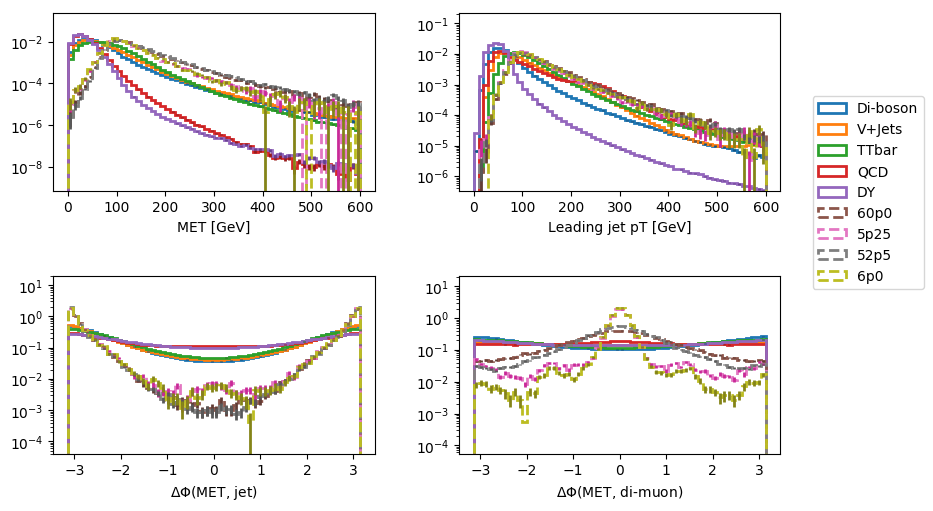

In [91]:
plt_maker = PM.PlotMaker(histos_from_file)

fig1, axes1 = plt.subplots(2, 2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_metjet):
    plt_maker.make_group_plot(axes1.flatten()[idx], var, bkg_grps, 0, density=True)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes1.flatten()[idx].set_xlabel(xlabel)
axes1[0,1].legend(loc=(1.1,-0.55));

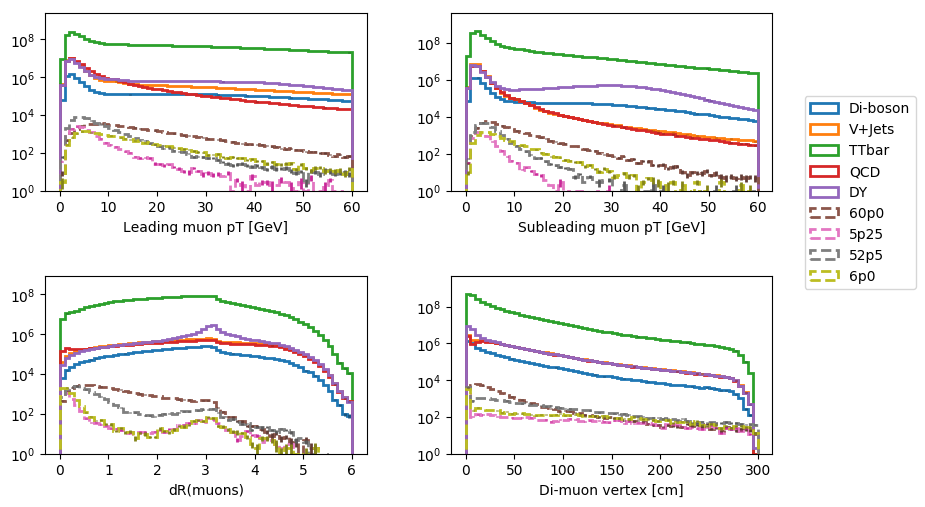

In [92]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for idx, var in enumerate(plot_vars_muons):
    plt_maker.make_group_plot(axes2.flatten()[idx], var, bkg_grps, 0, density=False)
    xlabel = all_plot_xlabels[all_plot_vars.index(var)]
    axes2.flatten()[idx].set_xlabel(xlabel)
axes2[0,1].legend(loc=(1.1,-0.55));

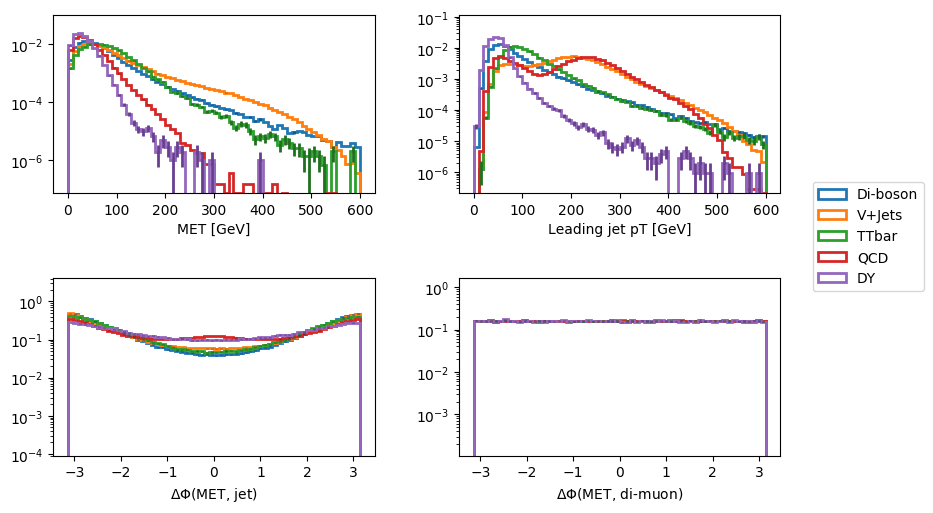

In [1155]:
fig1, axes1 = plt.subplots(2,2, figsize=(8,5))
fig1.tight_layout(h_pad=4.0, w_pad=3.0)
for var in allplotvars1:
    make_plot(var, axes1.flatten()[allplotvars1.index(var)], plot_groups=True, density=True, log=True)
axes1[0,1].legend(loc=(1.1,-0.55));

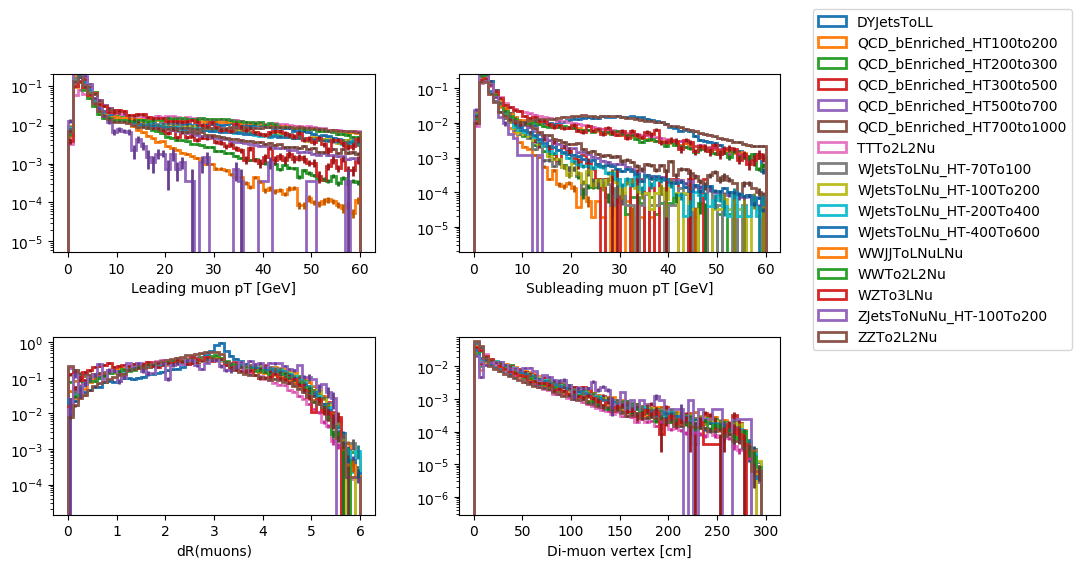

In [1158]:
fig2, axes2 = plt.subplots(2,2, figsize=(8,5))
fig2.tight_layout(h_pad=4.0, w_pad=3.0)
for var in allplotvars2:
    make_plot(var, axes2.flatten()[allplotvars2.index(var)], plot_groups=False, density=True, log=True)
axes2[0,1].legend(loc=(1.1,-0.55));